In [1]:
from qpe import *
from numpy import log

import qutip as qp
from time import time

from numpy import sign, ceil
from numpy.random import randint

from scipy.stats import unitary_group, gaussian_kde

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
matplotlib.rcParams['font.family']='serif'
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams.update({'font.size': 22})
matplotlib.rc('text', usetex=True)

In [2]:
def aux_info(channel_func, channel_pars, channel_args, dm_ini, pars, n_layers, n_copies=1, n_meas=0, dp=1e-5):
    """ For the optimized variables theta and x,
    calculates the expectations expecs, their derivatives excepcs_der,
    their variances disps, and quantum and classical Fisher informations. """

    n_inp = int(log2(len(dm_ini)))
    n_tot = n_inp*n_copies

    if n_meas == 0:
        n_meas = n_tot
    
    pars_ans = pars[:-2**n_meas]
    pars_est = pars[-2**n_meas:]
    
    ansatz = hea_cry_rzrx(n_tot, n_layers, pars_ans)
    projs = [reduce(kron, [diag(line), eye(2**(n_tot - n_meas))]) for line in eye(2**n_meas)]
    projs_u = [ansatz.conj().T@proj@ansatz for proj in projs]

    H = sum([x*proj for x, proj in zip(pars_est, projs_u)])
    
    dms_n = []
    dms_n_p = []
    dms_n_m = []
    for p in channel_pars:
        dm_n = reduce(kron, [channel_func(dm_ini, p, *channel_args)]*n_copies)
        dm_n_p = reduce(kron, [channel_func(dm_ini, p+dp, *channel_args)]*n_copies)
        dm_n_m = reduce(kron, [channel_func(dm_ini, p-dp, *channel_args)]*n_copies)
        dms_n.append(dm_n)
        dms_n_p.append(dm_n_p)
        dms_n_m.append(dm_n_m)

    expecs = []
    expecs_der = []
    disps = []
    CFIs = []
    QFIs = []
    for j in range(len(channel_pars)): # take a density matrix from the training set
        probs = [trace(dms_n[j]@proj).real for proj in projs_u]
        probs_der = [trace((dms_n_p[j] - dms_n_m[j])@proj).real/(2*dp) for proj in projs_u]
        expec = sum([out_i*prob_i for out_i, prob_i in zip(pars_est, probs)])
        expec_der = sum([out*prob_der for out, prob_der in zip(pars_est, probs_der)])
        disp = sum([out_i**2*prob_i for out_i, prob_i in zip(pars_est, probs)]) - expec**2
        CFI = sum([prob_der**2/prob if prob > 0 else 0 for prob_der, prob in zip(probs_der, probs)]) + 1e-10
        QFI = 2*(1 - sqrt(fidelity(dms_n_m[j], dms_n_p[j]))) / dp**2 + 1e-10 # via centered differences 
        expecs.append(expec)
        expecs_der.append(expec_der)
        disps.append(disp)
        CFIs.append(CFI)
        QFIs.append(QFI)
    
    return array(expecs), array(expecs_der), array(disps), array(CFIs), array(QFIs), H

# Single copy

## Depolarizing

In [3]:
channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

dm_ini = (eye(2) + X)/2

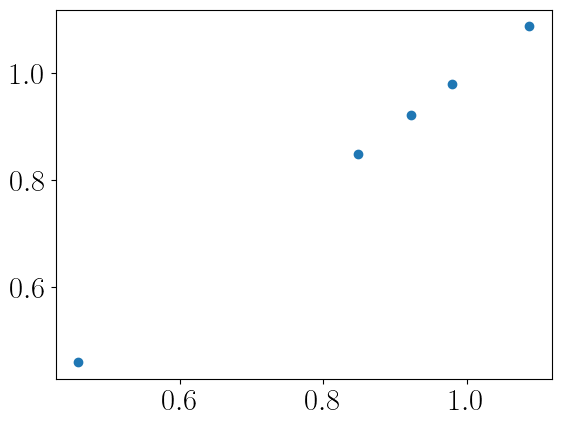

In [4]:
a = 0. + 1e-3
b = 4/3 - 1e-3
T = 5
V = 15


labels_train = np.sort(uniform(a, b, T))
labels_test = linspace(a, b, V)

dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)

In [5]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-5

x0 = concatenate([uniform(0, 2*pi, 2*n_inp*n_copies + (3*n_inp*n_copies - 1)*n_layers), normal(0., 1, 2**n_meas)])

In [6]:
fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
                          w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars = result.x

expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test, H = aux_info(channel_func, labels_test, 
                                                                             channel_args, dm_ini, pars, n_layers,
                                                                             n_copies=n_copies, n_meas=n_meas, dp=dp)

print("\n", result.message)

			Iteration: 34 | Cost: 0.00046610 | Time passed: 0 s
 Optimization terminated successfully.


In [7]:
save_path = r"/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + r"-n_copies=%d-n_meas=%d=n_layers=%d-w_ls=%f-w_var=%f" %(n_copies, n_meas, n_layers, w_ls, w_var)
save_path + file_info

'/home/kardashin/Work/QPE/Results/Channels/depolarizing-n_copies=1-n_meas=1=n_layers=1-w_ls=1.000000-w_var=0.000100'

In [26]:
### taken from channels_bayes.ipynb ###
expecs_bayes, expecs_der_bayes, disps_bayes = (array([0.55722873, 0.57286288, 0.58849702, 0.60413116, 0.6197653 , 0.63539944, 0.65103359, 0.66666773, 0.68230187, 0.69793601, 0.71357015, 0.72920429, 0.74483844, 0.76047258, 0.77610672]),
                                               array([0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836, 0.16665836]),
                                               array([0.00055272, 0.00546731, 0.00989304, 0.01382991, 0.01727794, 0.02023711, 0.02270743, 0.0246889 , 0.02618151, 0.02718527, 0.02770018, 0.02772624, 0.02726344, 0.02631179, 0.02487129]))

In [24]:
### taken from analytical.ipynb ###
expecs_theor, expecs_der_theor, disps_theor = (array([0.00133267, 0.09638038, 0.1914281 , 0.28647581, 0.38152352, 0.47657124, 0.57161895, 0.66666667, 0.76171438, 0.8567621 , 0.95180981, 1.04685752, 1.14190524, 1.23695295, 1.33200067]),
                                               array([0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075, 0.99900075]),
                                               array([0.001997  , 0.18277336, 0.34548159, 0.49012167, 0.61669363, 0.72519744, 0.81563312, 0.88800067, 0.94230007, 0.97853135, 0.99669448, 0.99678948, 0.97881635, 0.94277508, 0.88866567]))

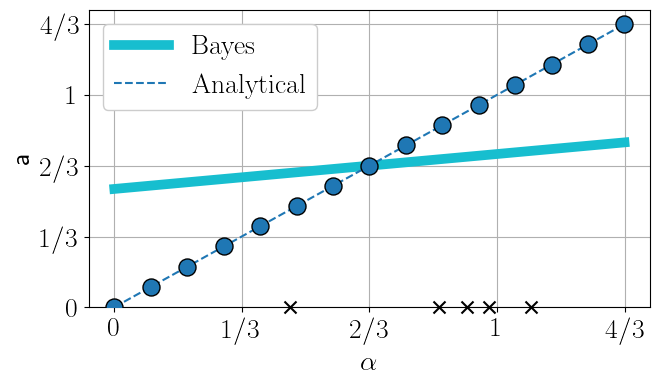

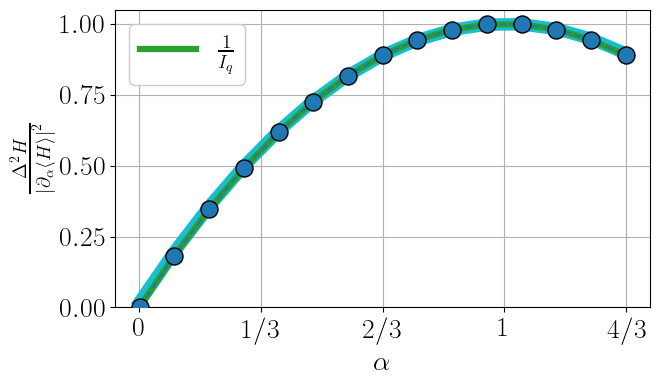

In [25]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4.25))
plt.scatter(labels_test, expecs_test, s=150, ec="black", zorder=10)
plt.plot(labels_test, expecs_bayes, zorder=2, linewidth=7, color="tab:cyan", label="Bayes")
# plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.plot(labels_test, expecs_theor, color="C0", linestyle="--", linewidth=1.5, label="Analytical")
plt.scatter(labels_train, [0]*T, color="black", s=75, marker="x", clip_on=False, zorder=10) # 
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid(zorder=0)
plt.legend(framealpha=1)
plt.ylim(0)
plt.tight_layout()
# plt.savefig(save_path + "depolar-plus-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4.25))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=150, ec="black", zorder=10)
plt.plot(labels_test, disps_theor/expecs_der_theor**2, color="C0", linestyle="--", linewidth=1.5, zorder=9)
plt.plot(labels_test, 1/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=4.5, linestyle="solid", zorder=8) # , color="tab:blue"
plt.plot(labels_test, disps_bayes/expecs_der_bayes**2, zorder=2, linewidth=9, color="tab:cyan")
plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
plt.legend(framealpha=1)
plt.ylim(0)
plt.tight_layout()
# plt.savefig(save_path + "depolar-plus-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

## Amplitude-damping

In [69]:
channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"

dm_ini_1 = eye(2)/2
dm_ini_2 = (I + X)/2

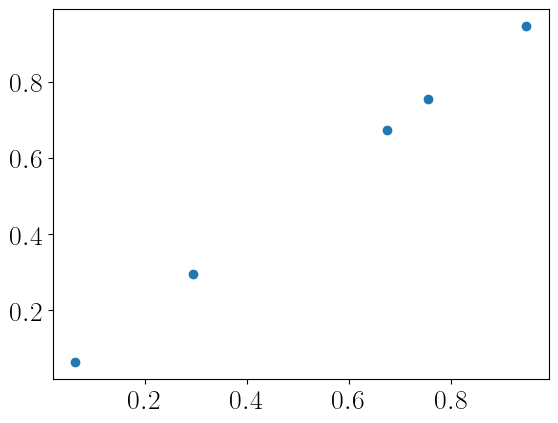

In [70]:
a = 0. + 1e-3
b = 1 - 1e-3
T = 5
V = 15


labels_train = np.sort(uniform(a, b, T))
labels_test = linspace(a, b, V)

dms_train_1 = [channel_func(dm_ini_1, p, *channel_args) for p in labels_train]
dms_train_2 = [channel_func(dm_ini_2, p, *channel_args) for p in labels_train]

dms_test_1 = [channel_func(dm_ini_1, p, *channel_args) for p in labels_test]
dms_test_2 = [channel_func(dm_ini_2, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)

In [71]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini_1)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-5

x0 = concatenate([uniform(0, 2*pi, 2*n_inp*n_copies + (3*n_inp*n_copies - 1)*n_layers), normal(0., 1, 2**n_meas)])

In [72]:
fvals_1, result_1 = train(dms_train_1, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
                          w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars_1 = result_1.x

expecs_test_1, expecs_der_test_1, disps_test_1, CFIs_test_1, QFIs_test_1, H_1 = aux_info(channel_func, labels_test, 
                                                                             channel_args, dm_ini_1, pars_1, n_layers,
                                                                             n_copies=n_copies, n_meas=n_meas, dp=dp)

print("\n", result_1.message)

			Iteration: 286 | Cost: 0.00029859 | Time passed: 0 s
 Optimization terminated successfully.


In [73]:
fvals_2, result_2 = train(dms_train_2, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
                          w_ls=w_ls, w_var=w_var, x0=None, options={}, fvals=[])
pars_2 = result_2.x

expecs_test_2, expecs_der_test_2, disps_test_2, CFIs_test_2, QFIs_test_2, H_2 = aux_info(channel_func, labels_test, 
                                                                             channel_args, dm_ini_2, pars_2, n_layers,
                                                                             n_copies=n_copies, n_meas=n_meas, dp=dp)

print("\n", result_2.message)

			Iteration: 53 | Cost: 0.00029754 | Time passed: 0 s
 Optimization terminated successfully.


In [74]:
save_path = r"/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + r"-n_copies=%d-n_meas=%d=n_layers=%d-w_ls=%f-w_var=%f" %(n_copies, n_meas, n_layers, w_ls, w_var)
save_path + file_info

'/home/kardashin/Work/QPE/Results/Channels/ad-n_copies=1-n_meas=1=n_layers=1-w_ls=1.000000-w_var=0.000100'

In [75]:
### taken from channels_bayes.ipynb ###
expecs_1_bayes, expecs_der_1_bayes, disps_1_bayes = (array([0.44555419, 0.4533323 , 0.46111042, 0.46888853, 0.47666665, 0.48444476, 0.49222287, 0.50000099, 0.5077791 , 0.51555722, 0.52333533, 0.53111345, 0.53889156, 0.54666967, 0.55444779]),
                                                     array([0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592, 0.11111592]),
                                                     array([0.01234551, 0.01226773, 0.01206895, 0.01174916, 0.01130839, 0.01074661, 0.01006383, 0.00926006, 0.00833529, 0.00728952, 0.00612275, 0.00483499, 0.00342622, 0.00189646, 0.0002457 ]))
expecs_2_bayes, expecs_der_2_bayes, disps_2_bayes = (array([0.43751589, 0.44563628, 0.45385782, 0.46219329, 0.47065842, 0.47927293, 0.4880621 , 0.4970593 , 0.50631005, 0.51587943, 0.52586625, 0.5364343 , 0.54789463, 0.56100684, 0.57982018]),
                                                     array([0.11533559, 0.11670054, 0.11823079, 0.11996268, 0.12194476, 0.12424371, 0.1269541 , 0.13021538, 0.13424363, 0.1393959 , 0.14631573, 0.15631813, 0.17268183, 0.20735775, 0.44243975]),
                                                     array([0.00637372, 0.00747026, 0.00844611, 0.00929747, 0.01001985, 0.01060785, 0.0110548 , 0.01135231, 0.01148939, 0.0114511 , 0.01121583, 0.01074965, 0.00999165, 0.0088022 , 0.00649494]))

In [76]:
### taken from analytical.ipynb ###
expecs_1_theor, expecs_der_1_theor, disps_1_theor = (array([0.01039169, 0.08033573, 0.15027978, 0.22022382, 0.29016787, 0.36011191, 0.43005596, 0.5       , 0.56994404, 0.63988809, 0.70983213, 0.77977618, 0.84972022, 0.91966427, 0.98960831]),
                                                     array([0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192, 0.99840192]),
                                                     array([0.99830208, 0.99201215, 0.97593787, 0.95007927, 0.91443632, 0.86900903, 0.8137974 , 0.74880144, 0.67402113, 0.58945649, 0.49510751, 0.39097419, 0.27705653, 0.15335453, 0.0198682 ]))
expecs_2_theor, expecs_der_2_theor, disps_2_theor = (array([0.00219285, 0.0731739 , 0.14417205, 0.21518949, 0.28622891, 0.3572937 , 0.42838822, 0.49951823, 0.57069166, 0.6419199 , 0.71322043, 0.78462261, 0.85618353, 0.92804977, 1.00144306]),
                                                     array([0.99561502, 0.9958415 , 0.99609571, 0.99638379, 0.99671401, 0.99709776, 0.99755126, 0.99809858, 0.99877727, 0.99965   , 1.00083126, 1.00255982, 1.00545205, 1.01193686, 1.1794432 ]),
                                                     array([0.97934875, 0.97587352, 0.9623172 , 0.9386716 , 0.90492706, 0.86107185, 0.80709156, 0.74296788, 0.66867683, 0.58418555, 0.48944615, 0.3843824 , 0.26885449, 0.14252612, 0.00285237]))

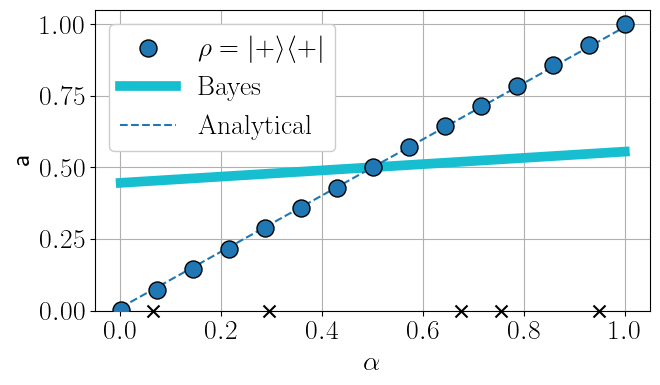

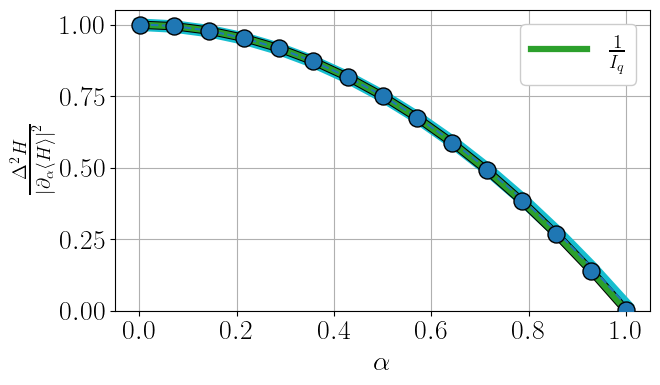

In [77]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4.25))
plt.scatter(labels_test, expecs_test_1, s=150, ec="black", zorder=10, label=r"$\rho = |+ \rangle\langle +|$")
plt.plot(labels_test, expecs_1_bayes, zorder=2, linewidth=7, color="tab:cyan", label="Bayes")
# plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.plot(labels_test, expecs_1_theor, color="C0", linestyle="--", linewidth=1.5, label="Analytical")
plt.scatter(labels_train, [0]*T, color="black", s=75, marker="x", clip_on=False, zorder=10) # 
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
plt.grid(zorder=0)
plt.legend(framealpha=1)
plt.ylim(0)
plt.tight_layout()
# plt.savefig(save_path + "AD-plus-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4.25))
plt.scatter(labels_test, n_copies*disps_test_1/expecs_der_test_1**2, s=150, ec="black", zorder=10)
plt.plot(labels_test, disps_1_theor/expecs_der_1_theor**2, color="C0", linestyle="--", linewidth=1.5, zorder=9)
plt.plot(labels_test, 1/QFIs_test_1, color="C2", label=r"$\frac{1}{I_q}$", linewidth=4.5, linestyle="solid", zorder=8) # , color="tab:blue"
plt.plot(labels_test, 1/QFIs_test_1, color="black", linewidth=6, linestyle="solid", zorder=7) # , color="tab:blue"
plt.plot(labels_test, disps_1_bayes/expecs_der_1_bayes**2, zorder=2, linewidth=9, color="tab:cyan")
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.legend(framealpha=1)
plt.ylim(0)
plt.tight_layout()
# plt.savefig(save_path + "AD-plus-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

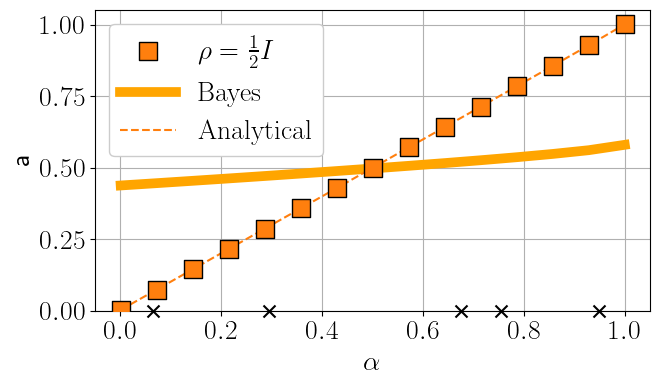

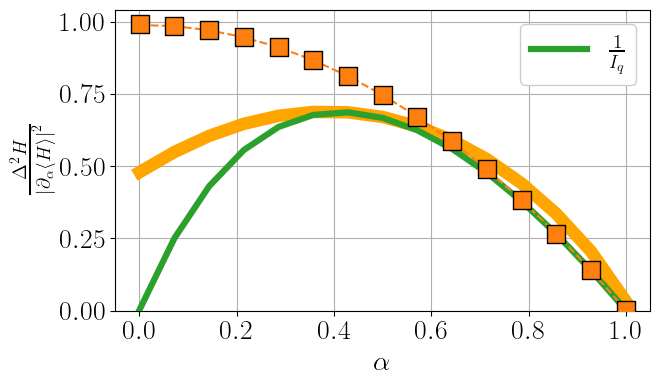

In [79]:
matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4.25))
plt.scatter(labels_test, expecs_test_2, s=150, marker="s", color="C1", ec="black", zorder=10, label=r"$\rho = \frac{1}{2}I$")
plt.plot(labels_test, expecs_2_bayes, zorder=2, linewidth=7, color="orange", label="Bayes")
plt.plot(labels_test, expecs_2_theor, color="C1", linestyle="--", linewidth=1.5, label="Analytical")
plt.scatter(labels_train, [0]*T, color="black", s=75, marker="x", clip_on=False, zorder=10) # 
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
plt.grid(zorder=0)
plt.legend(framealpha=1)
plt.ylim(0)
plt.tight_layout()
# plt.savefig(save_path + "AD-id-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


plt.figure(figsize=(7, 4.25))
plt.scatter(labels_test, n_copies*disps_test_2/expecs_der_test_2**2, color="C1", s=150, ec="black", marker="s", zorder=10)
plt.plot(labels_test, disps_2_theor/expecs_der_2_theor**2, color="C1", linestyle="--", linewidth=1.5, zorder=9)
plt.plot(labels_test, 1/QFIs_test_2, color="C2", label=r"$\frac{1}{I_q}$", linewidth=4.5, linestyle="solid", zorder=8) # , color="tab:blue"
plt.plot(labels_test, disps_2_bayes/expecs_der_2_bayes**2, zorder=2, linewidth=9, color="orange")
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
plt.grid()
plt.legend(framealpha=1)
plt.ylim(0)
plt.tight_layout()
# plt.savefig(save_path + "AD-id-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

## General

In [120]:
channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
# channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
# channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

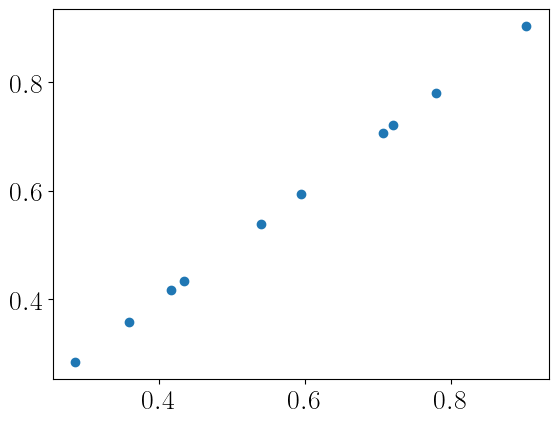

In [121]:
a = 0. + 1e-2
b = 1 - 1e-2

# labels_train = linspace(a, b, 10)#[1:-1]
labels_train = np.sort(uniform(a, b, 10))
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 20)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)

In [122]:
def train(dms, labels, n_layers, n_copies=1, n_meas=0, method="BFGS", w_ls=1e0, w_var=1e-4, x0=None, options={}, save_data=False, file_name=None, fvals=[]):

    n_inp = int(log2(len(dms[0])))
    n_tot = n_inp*n_copies
    d = 2**n_tot
        
    if n_meas == 0:
        n_meas = n_tot
                
    n_pars_est = 2**n_meas
    # n_pars_ans = (3*n_layers + 2)*n_tot # cry  
    n_pars_ans = 2*n_tot + (3*n_tot - 1)*n_layers
    
    d_diff = 2**(n_tot - n_meas)
    
    dms_cop = [reduce(kron, [dm]*n_copies) for dm in dms]

    fval_cont = [0]
    def fun(x):
        x_ans, x_est = x[:n_pars_ans], x[n_pars_ans:]
        U = hea_cry_rzrx(n_tot, n_layers, x_ans)
        H_u = (U.conj().T*kron_A_I_diag(x_est, d_diff))@U
        H_u_sq = H_u@H_u
        expecs = []
        disps = []
        for dm in dms_cop:
            expecs.append(trace(dm@H_u).real)
            disps.append(trace(dm@H_u_sq).real)
        f = w_ls*np.sum((array(expecs) - array(labels))**2)
        f += w_var*np.sum(array(disps) - array(expecs)**2)
        fval_cont[0] = f
        return f
    
    if file_name is None:
        file_name = "pars-c=%d-m=%d=l=%d-w_ls=%f-w_var=%f-n_train=%d" %(n_copies, n_meas, n_layers, w_ls, w_var, len(labels))

    time_loc = time()
    
    def callback(x):
        fvals.append(fval_cont[0])
        print("\t\t\tIteration: %d | Cost: %.8f | Time passed: %d s" %(len(fvals), fval_cont[0], time() - time_loc), end="\r")
        if save_data == True:
            np.save(file_name + "-pars", x)
            np.save(file_name + "-fvals", fvals)
        return None
    
    if method in ["Nelder-Mead", "L-BFGS-B", "SLSQP", "TNC", "Powell", "COBYLA"]:
        bounds = [(0, 2*pi)]*n_pars_ans + [(None,  None)]*n_pars_est
    else:
        bounds = None
    if x0 is None:
        x0_ans = normal(pi, 1, n_pars_ans)
        x0_est = normal(0, 1, n_pars_est)
        x0 = concatenate([x0_ans, x0_est])
    
    optimization_result = minimize(fun=fun, x0=x0, bounds=bounds, method=method, callback=callback, options=options) # "maxiter": int(1e10)

    return fvals, optimization_result

In [123]:
method = "BFGS"
n_copies = 1
n_inp = int(log2(len(dm_ini)))
n_meas = n_inp*n_copies
n_layers = 1

w_ls = 1
w_var = 1e-4

dp = 1e-2

# x0 = concatenate([uniform(0, 2*pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), normal(0., 1, 2**n_meas)])
# x0 = concatenate([uniform(0, 2*pi, (3*n_layers + 2)*n_inp*n_copies), normal(0., 1, 2**n_meas)])
x0 = None

fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
                      w_ls=w_ls, w_var=w_var, x0=x0, options={})
pars = result.x

expecs_train, expecs_der_train, disps_train, CFIs_train, QFIs_train, H = aux_info(channel_func, labels_train, 
                                                                               channel_args, dm_ini, pars, n_layers,
                                                                               n_copies=n_copies, n_meas=n_meas, dp=dp)

print("\n", result.message)

			Iteration: 67 | Cost: 0.00062564 | Time passed: 0 s
 Optimization terminated successfully.


In [124]:
expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test, H = aux_info(channel_func, labels_test, 
                                                                          channel_args, dm_ini, pars, n_layers,
                                                                          n_copies=n_copies, n_meas=n_meas, dp=dp)

In [125]:
save_path = r"/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + r"-n_copies=%d-n_meas=%d=n_layers=%d-w_ls=%f-w_var=%f" %(n_copies, n_meas, n_layers, w_ls, w_var)
save_path + file_info

'/home/kardashin/Work/QPE/Results/Channels/ad-n_copies=1-n_meas=1=n_layers=1-w_ls=1.000000-w_var=0.000100'

Cost: 0.0006256387245507195

n_copies: 1 | n_meas: 1 | n_layers: 1
w_ls: 1.000000 | w_var: 0.000100 

Sum error: 6.190813921985505e-06


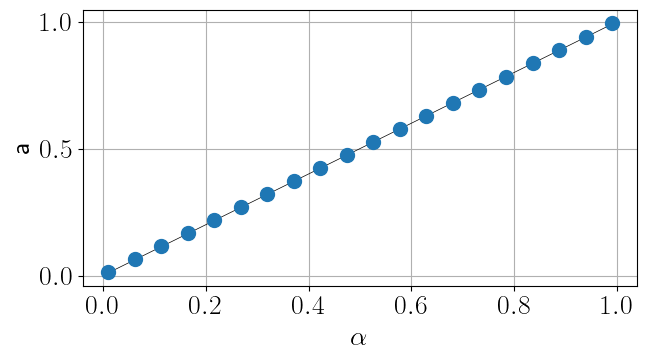

Sum var: 0.6382876615894968
Sum difference: 0.2074872214736315


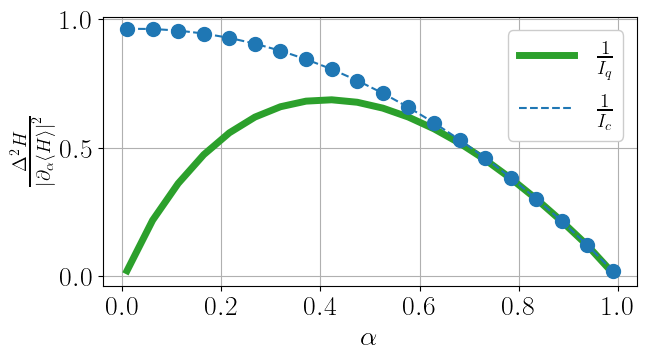

In [126]:
print("Cost:", result.fun)
print("\nn_copies: %d | n_meas: %d | n_layers: %d" %(n_copies, n_meas, n_layers))
print("w_ls: %f | w_var: %f " %(w_ls, w_var))

print("\nSum error:", sum((labels_test - expecs_test)**2/len(CFIs_test)))

matplotlib.rcParams.update({'font.size': 20})

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, expecs_test, s=100, zorder=10)
plt.plot(labels_test, labels_test, color="black", linewidth=0.5)
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$\mathsf{a}$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
# plt.yticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()


print("Sum var:", n_copies*sum(disps_test)/len(CFIs_test))
print("Sum difference:", sum(np.abs(1/CFIs_test - 1/QFIs_test))/len(CFIs_test))
# print("Least squares:", sum((CFIs_test - QFIs_test)**2)/len(CFIs_test))

plt.figure(figsize=(7, 4))
plt.scatter(labels_test, n_copies*disps_test/expecs_der_test**2, s=100, zorder=10)
# plt.scatter(labels_test, n_copies*disps_test, s=100, zorder=10)
# plt.scatter(labels_test, [(1 - a**2) for a in labels_test], s=100, zorder=10)
# plt.scatter(labels_test, n_copies*disps_test, s=100, zorder=10)
plt.plot(np.sort(labels_test), n_copies/QFIs_test, color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # , color="tab:blue"
# plt.plot(np.sort(labels_test), [n_copies]*len(QFIs_test), color="C2", label=r"$\frac{1}{I_q}$", linewidth=5, linestyle="solid") # unitary channel
plt.plot(np.sort(labels_test), n_copies/CFIs_test, color="C0", label=r"$\frac{1}{I_c}$", linewidth=1.5, linestyle="dashed") # , color="tab:red"
plt.ylabel(r"$\frac{\Delta^2 H}{\left|\partial_\alpha \langle H \rangle \right|^2}$" )
plt.xlabel(r"$\alpha$")
# plt.xticks([0, 1/3, 2/3, 3/3, 4/3], [r"$0$", r"$1/3$", r"$2/3$", r"$1$", r"$4/3$"]) # for the depolarizing channel
plt.grid()
plt.legend(framealpha=1)
plt.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()

### Inversion

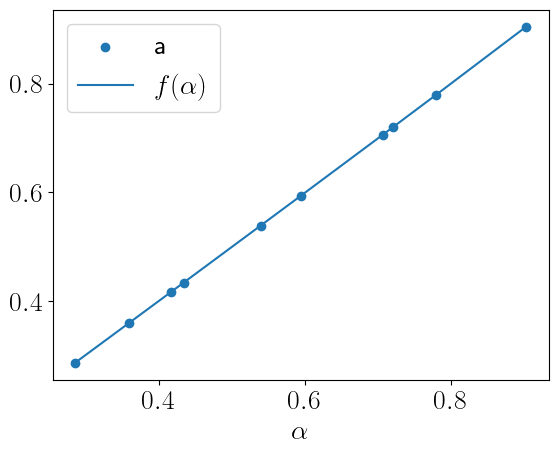

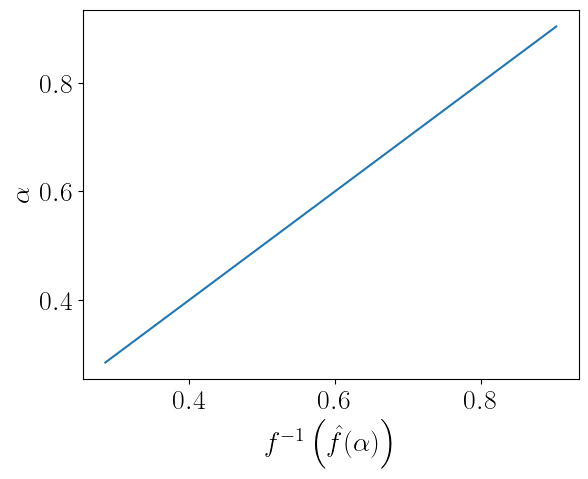

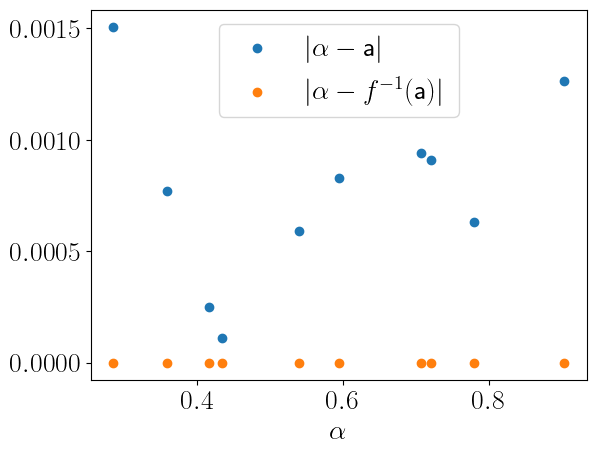

In [138]:
m = 9
f = np.poly1d(np.polyfit(labels_train, expecs_train, m))
f_inv = np.poly1d(np.polyfit(expecs_train, labels_train, m))

plt.scatter(labels_train, expecs_train, label=r"$\mathsf{a}$")
plt.plot(labels_train, f(labels_train), label=r"$f(\alpha)$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

plt.plot(f_inv(expecs_train), labels_train, label="")
plt.xlabel(r"$f^{-1}\left(\hat{f}(\alpha)\right)$")
plt.ylabel(r"$\alpha$")
# plt.legend()
plt.show()

# plt.ylabel(r"$|\hat{\alpha} - \alpha|$")
plt.scatter(labels_train, np.abs(labels_train - expecs_train),  label=r"$|\alpha - \mathsf{a}|$")
plt.scatter(labels_train, np.abs(labels_train - f_inv(expecs_train)), label=r"$|\alpha - f^{-1}(\mathsf{a})|$")
plt.xlabel(r"$\alpha$")
plt.legend()
plt.show()

# Multiple copies

## Unitary

In [4]:
# channel_func = generalized_amplitude_damping_channel; channel_args = [0, 0]; channel_name = "ad"
channel_func = z_rot; channel_args = [0]; channel_name = "zrot"
# channel_func = depolarizing_channel; channel_args = []; channel_name = "depolarizing"

# sv_ini = array(rand_ket(2))
# dm_ini = outer(sv_ini, sv_ini.conj().T)
# dm_ini = array(qp.rand_dm_hs(2))
# dm_ini = eye(2)/2
dm_ini = (eye(2) + X)/2
# dm_ini = (eye(2) + Z)/2

(0.001, 3.1405926535897932)

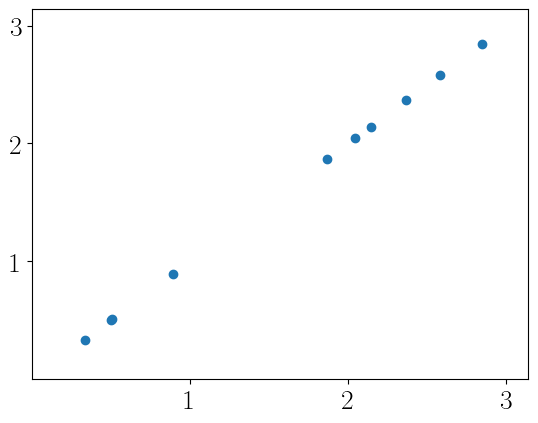

In [210]:
a = 1e-3
b = pi - 1e-3
T = 10

# labels_train = linspace(a, b, 1000)#[1:-1]
labels_train = np.sort(uniform(a, b, T))
dms_train = [channel_func(dm_ini, p, *channel_args) for p in labels_train]

labels_test = linspace(a, b, 21)
dms_test = [channel_func(dm_ini, p, *channel_args) for p in labels_test]

plt.scatter(labels_train, labels_train)
plt.xlim(a, b)
plt.ylim(a, b)

In [211]:
method = "BFGS"
w_ls = 1
w_var = 1e-4

n_copies_list = [1, 2]#, 3, 4]
n_layers_list = [1, 2]#, 3, 3]

pars_list = []
for n_copies, n_layers in zip(n_copies_list, n_layers_list):
    print("n_copies:", n_copies)
    n_inp = int(log2(len(dm_ini)))
    n_meas = n_inp*n_copies
    # x0 = concatenate([uniform(0, pi, (3*n_inp*n_copies - 1)*n_layers + 2*n_inp*n_copies), uniform(-0.1, 0.1, 2**n_meas)])
    x0 = None
    fvals, result = train(dms_train, labels_train, n_layers, n_copies=n_copies, n_meas=n_meas, method=method, 
                          w_ls=w_ls, w_var=w_var, x0=x0, options={})
    pars = result.x
    pars_list.append(pars)
    print("\n", result.message)
    print()

n_copies: 1
			Iteration: 5262 | Cost: 0.03957746 | Time passed: 0 ss
 Optimization terminated successfully.

n_copies: 2
			Iteration: 6112 | Cost: 0.00077759 | Time passed: 6 ss
 Optimization terminated successfully.



In [212]:
dp = 1e-5
aux_infos_list = []
for i in range(len(n_copies_list)):
    n_meas = int(log2(len(dm_ini)))*n_copies_list[i]
    expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test, H_test = aux_info(channel_func, labels_test, channel_args, dm_ini, 
                                                                              pars_list[i], n_layers_list[i], n_copies=n_copies_list[i], n_meas=n_meas, dp=dp)
    aux_infos_list.append([expecs_test, expecs_der_test, disps_test, CFIs_test, QFIs_test])

In [213]:
expecs_1_bayes = array([0.93420589, 0.93590256, 0.94017503, 0.94700597, 0.95636767, 0.96822214, 0.98252129, 0.99920712, 1.01821191, 1.03945857, 1.06286091, 1.08832396, 1.11574444, 1.14501108, 1.17600516, 1.20860093, 1.24266615, 1.2780626 , 1.31464669, 1.35226999, 1.39077985, 1.43002005, 1.46983138, 1.51005232, 1.5505197 , 1.59106933, 1.63153669, 1.67175763, 1.71156894, 1.75080912, 1.78931896, 1.82694223, 1.86352628, 1.8989227 , 1.93298787, 1.9655836 , 1.99657763, 2.02584422, 2.05326464, 2.07872763, 2.1021299 , 2.1233765 , 2.14238122, 2.15906698, 2.17336606, 2.18522046, 2.19458208, 2.20141294, 2.20568533, 2.20738192])
expecs_2_bayes = array([0.69908531, 0.70491963, 0.71421749, 0.72689933, 0.7428733 , 0.76203636, 0.78427526, 0.80946761, 0.83748291, 0.86818348, 0.90142547, 0.93705972, 0.9749326 , 1.01488682, 1.05676206, 1.10039563, 1.14562305, 1.19227841, 1.24019488, 1.28920494, 1.33914064, 1.3898338 , 1.44111612, 1.49281928, 1.54477493, 1.59681475, 1.64877041, 1.7004736 , 1.75175597, 1.8024492 , 1.85238497, 1.90139511, 1.94931169, 1.99596717, 2.04119472, 2.08482844, 2.12670384, 2.16665823, 2.2045313 , 2.24016574, 2.27340794, 2.30410873, 2.33212426, 2.35731686, 2.37955601, 2.39871933, 2.41469357, 2.42737567, 2.43667382, 2.44250842])
expecs_der_1_bayes = array([0.0063667 , 0.04688082, 0.08720474, 0.12717486, 0.16662902, 0.20540716, 0.24335194, 0.28030943, 0.31612968, 0.35066736, 0.38378236, 0.41534033, 0.44521322, 0.47327985, 0.49942635, 0.52354664, 0.54554285, 0.56532576, 0.5828151 , 0.5979399 , 0.61063882, 0.62086033, 0.62856296, 0.63371546, 0.63629693, 0.63629689, 0.63371535, 0.62856277, 0.62086006, 0.61063848, 0.59793949, 0.5828146 , 0.5653252 , 0.54554223, 0.52354594, 0.4994256 , 0.47327904, 0.44521235, 0.4153394 , 0.38378139, 0.35066634, 0.31612862, 0.28030833, 0.24335082, 0.205406  , 0.16662785, 0.12717366, 0.08720353, 0.0468796 , 0.00636548])
expecs_der_2_bayes = array([0.06403289, 0.11895718, 0.1727337 , 0.22516221, 0.27605846, 0.3252544 , 0.37259833, 0.41795466, 0.46120361, 0.50224061, 0.54097559, 0.57733209, 0.61124632, 0.64266597, 0.67154913, 0.697863  , 0.72158271, 0.74269006, 0.76117234, 0.7770212 , 0.7902316 , 0.80080088, 0.80872793, 0.81401251, 0.81665479, 0.81665491, 0.81401287, 0.80872852, 0.80080171, 0.79023266, 0.77702249, 0.76117386, 0.74269181, 0.72158468, 0.69786519, 0.67155153, 0.64266859, 0.61124914, 0.57733511, 0.54097879, 0.502244  , 0.46120717, 0.41795838, 0.3726022 , 0.32525841, 0.27606259, 0.22516645, 0.17273803, 0.11896159, 0.06403736])
disps_1_bayes = array([4.05348975e-05, 2.19781125e-03, 7.60466629e-03, 1.61734449e-02, 2.77652312e-02, 4.21921010e-02, 5.92201679e-02, 7.85733753e-02, 9.99379719e-02, 1.22967598e-01, 1.47288901e-01, 1.72507586e-01, 1.98214813e-01, 2.23993820e-01, 2.49426681e-01, 2.74101082e-01, 2.97617006e-01, 3.19593215e-01, 3.39673435e-01, 3.57532129e-01, 3.72879772e-01, 3.85467553e-01, 3.95091399e-01, 4.01595290e-01, 4.04873786e-01, 4.04873736e-01, 4.01595142e-01, 3.95091156e-01, 3.85467218e-01, 3.72879351e-01, 3.57531628e-01, 3.39672863e-01, 3.19592581e-01, 2.97616320e-01, 2.74100356e-01, 2.49425925e-01, 2.23993048e-01, 1.98214037e-01, 1.72506818e-01, 1.47288154e-01, 1.22966884e-01, 9.99373025e-02, 7.85727613e-02, 5.92196193e-02, 4.21916267e-02, 2.77648389e-02, 1.61731409e-02, 7.60445555e-03, 2.19769719e-03, 4.05193674e-05])
disps_2_bayes = array([0.00205041, 0.00709192, 0.01497484, 0.02546631, 0.03829949, 0.05318072, 0.06979669, 0.08782146, 0.10692308, 0.12676978, 0.14703545, 0.16740451, 0.18757592, 0.20726654, 0.22621359, 0.24417649, 0.26093798, 0.27630465, 0.29010701, 0.30219917, 0.3124582 , 0.32078341, 0.3270955 , 0.33133582, 0.33346563, 0.33346571, 0.33133607, 0.32709592, 0.32078399, 0.31245893, 0.30220005, 0.29010803, 0.27630579, 0.26093923, 0.24417784, 0.22621502, 0.20726804, 0.18757746, 0.16740607, 0.14703701, 0.12677131, 0.10692457, 0.08782287, 0.06979801, 0.05318192, 0.03830055, 0.0254672 , 0.01497554, 0.00709242, 0.0020507 ])

In [214]:
expecs_1_theor = array([0.29768409328308487, 0.3002998389076938, 0.30813632712167305, 0.3211613561140303, 0.33932140324677573, 0.36254184499092323, 0.3907272635705768, 0.4237618390550393, 0.4615098252877509, 0.5038161076963636, 0.5505068406917917, 0.6013901620370259, 0.6562569812502203, 0.714881838802332, 0.7770238325786873, 0.8424276077974431, 0.9108244063171594, 0.981933171021652, 1.0554617007439675, 1.131107850983657, 1.208560775483337, 1.2875022035626387, 1.3676077479607003, 1.448548237813005, 1.5299910712850693, 1.6116015823047234, 1.6930444157767877, 1.7739849056290924, 1.8540904500271542, 1.9330318781064557, 2.0104848026061357, 2.086130952845825, 2.1596594825681406, 2.230768247272634, 2.29916504579235, 2.3645688210111055, 2.4267108147874605, 2.4853356723395725, 2.5402024915527672, 2.591085812898001, 2.637776545893429, 2.6800828283020417, 2.7178308145347536, 2.750865390019216, 2.77905080859887, 2.802271250343017, 2.820431297475763, 2.83345632646812, 2.8412928146820993, 2.8439085603067085])
expecs_2_theor = array([0.05258483790892554, 0.09261920419920633, 0.13827326526074377, 0.18891242876119468, 0.2438964191672898, 0.30258900529507204, 0.36436735167360457, 0.4286308446748074, 0.494809254240845, 0.5623701041807583, 0.6308251382053813, 0.6997357848859729, 0.7687175422896111, 0.8374432218701711, 0.9056450109640035, 0.9731153336254181, 1.0397065101998884, 1.1053292366294776, 1.1699499246735217, 1.2335869636733103, 1.2963059828700003, 1.3582142102957326, 1.4194540396171238, 1.4801959297635787, 1.5406307734975326, 1.6009618800922603, 1.661396723826214, 1.7221386139726689, 1.7833784432940603, 1.8452866707197926, 1.9080056899164823, 1.971642728916271, 2.036263416960315, 2.1018861433899048, 2.1684773199643748, 2.2359476426257894, 2.304149431719622, 2.372875111300182, 2.4418568687038196, 2.510767515384411, 2.579222549409034, 2.646783399348948, 2.712961808914985, 2.777225301916188, 2.839003648294721, 2.8976962344225026, 2.9526802248285984, 3.003319388329049, 3.0489734493905867, 3.0890078156808674])
expecs_der_1_theor = array([0.0, 0.08156858086123851, 0.1628019789273125, 0.24336638874105918, 0.32293075386154213, 0.4011681272459786, 0.4777570147452679, 0.5523826961924106, 0.6247385186551819, 0.694527156538807, 0.7614618333606064, 0.8252675001760761, 0.8856819658139985, 0.9424569742762053, 0.9953592248747243, 1.0441713309143488, 1.088692712981198, 1.128740423166553, 1.1641498968390551, 1.194775628876076, 1.2204917715754762, 1.241192651790809, 1.256793205164944, 1.2672293256777596, 1.2724581290715273, 1.2724581290715273, 1.2672293256777596, 1.2567932051649442, 1.241192651790809, 1.2204917715754764, 1.194775628876076, 1.1641498968390553, 1.1287404231665532, 1.088692712981198, 1.044171330914349, 0.9953592248747244, 0.9424569742762056, 0.8856819658139986, 0.8252675001760765, 0.7614618333606067, 0.6945271565388076, 0.6247385186551823, 0.5523826961924108, 0.4777570147452684, 0.4011681272459789, 0.32293075386154274, 0.2433663887410595, 0.16280197892731313, 0.08156858086123893, 1.5591128217255779e-16])
expecs_der_2_theor = array([0.5773515375602168, 0.6698836334878897, 0.7526137524852288, 0.8253760413381671, 0.8881584970306191, 0.9410983036530133, 0.9844747799919991, 1.0187000733253349, 1.0443077716242488, 1.061939640136607, 1.0723307186351714, 1.076293041970372, 1.0746982685359345, 1.0684595184802548, 1.0585127356967, 1.0457978946048982, 1.0312403743813894, 1.0157328195884712, 1.0001177971494888, 0.9851715454792018, 0.9715890925356734, 0.9599709959327082, 0.9508119304317907, 0.9444913165814975, 0.9412661495135107, 0.9412661495135107, 0.9444913165814974, 0.9508119304317908, 0.9599709959327081, 0.9715890925356732, 0.9851715454792018, 1.0001177971494888, 1.0157328195884707, 1.0312403743813896, 1.0457978946048982, 1.0585127356967, 1.0684595184802546, 1.0746982685359345, 1.076293041970372, 1.0723307186351712, 1.061939640136607, 1.0443077716242488, 1.018700073325335, 0.9844747799919993, 0.9410983036530136, 0.8881584970306196, 0.8253760413381674, 0.7526137524852295, 0.66988363348789, 0.5773515375602171])
disps_1_theor = array([1.3877787807814457e-17, 0.006653433383716489, 0.026504484342648973, 0.05922719916886439, 0.10428427178958391, 0.16093586631804588, 0.22825176513831016, 0.305126643052797, 0.390298216691471, 0.48236797116988067, 0.579824123664896, 0.6810664468468697, 0.7844325445681488, 0.8882251483618598, 0.9907399865432118, 1.0902937683034424, 1.185251823298361, 1.2740549428902095, 1.3552449823103827, 1.427488803356223, 1.4896001644834445, 1.5405591988595002, 1.5795291605487738, 1.605870163857709, 1.6191496902402114, 1.6191496902402118, 1.6058701638577086, 1.5795291605487733, 1.5405591988595004, 1.4896001644834445, 1.4274888033562236, 1.355244982310384, 1.27405494289021, 1.1852518232983593, 1.090293768303443, 0.990739986543212, 0.8882251483618608, 0.7844325445681513, 0.6810664468468692, 0.5798241236648964, 0.4823679711698814, 0.39029821669147324, 0.30512664305279813, 0.22825176513831025, 0.16093586631804602, 0.10428427178958444, 0.05922719916886443, 0.026504484342648738, 0.006653433383716489, 0.0])
disps_2_theor = array([0.16666739896157323, 0.22573476123496042, 0.2885754744346384, 0.352358300116294, 0.41447982241390624, 0.4726444901105309, 0.52492665769392, 0.5698135157561643, 0.6062287241164386, 0.6335374095619775, 0.6515339259404441, 0.660414369043262, 0.6607362746663076, 0.653368198961576, 0.6394319899961115, 0.6202405222532087, 0.5972335035288139, 0.5719137039631215, 0.5457856308200795, 0.5202983119063944, 0.49679348537224444, 0.4764601503676955, 0.4602961323038306, 0.4490770720391293, 0.4433330663703927, 0.4433330663703927, 0.4490770720391293, 0.4602961323038315, 0.4764601503676955, 0.49679348537224577, 0.5202983119063949, 0.5457856308200806, 0.571913703963121, 0.5972335035288134, 0.6202405222532086, 0.639431989996111, 0.6533681989615747, 0.6607362746663066, 0.6604143690432647, 0.6515339259404458, 0.6335374095619777, 0.6062287241164377, 0.5698135157561657, 0.5249266576939204, 0.47264449011053244, 0.4144798224139077, 0.35235830011629155, 0.28857547443463716, 0.2257347612349605, 0.16666739896157523])

In [215]:
expecs_1_inf = array([0.29746871123366464, 0.3133246423789885, 0.3601043702319663, 0.4366574857701423, 0.5411013915767671, 0.670867598755152, 0.8227648913149626, 0.993057804689225, 1.1775584884350765, 1.371729694026883, 1.570796355061605, 1.7698630158913562, 1.9640342208732864, 2.1485349036193577, 2.3188278156285205, 2.470725106491482, 2.600491311683001, 2.704935215261601, 2.781488328385385, 2.8282680536969798, 2.844123982236428])
expecs_2_inf = array([0.05302759199136005, 0.16109245430434804, 0.2972587597392423, 0.45229601477644166, 0.6177266040829668, 0.786490332056096, 0.953410547680867, 1.1154217939226763, 1.271543573225847, 1.422610809028816, 1.5707963401097218, 1.7189818658528435, 1.870049086762398, 2.0261708448521514, 2.188182068551752, 2.3551022664926347, 2.5238659883203693, 2.6892965894183845, 2.8443338795324706, 2.980500246945512, 3.0885651994943686])
expecs_der_1_inf = array([0.0012733363997511856, 0.20032424081954125, 0.39444876313711985, 0.5788729849934505, 0.7490615381988782, 0.900829138763447, 1.0304435114809305, 1.1347171743262554, 1.2110858249766996, 1.2576714024066633, 1.2733282721455323, 1.2576713998005804, 1.2110858198583152, 1.1347171667698541, 1.0304435016880693, 0.9008291269961577, 0.749061524725685, 0.5788729701442094, 0.39444874729440227, 0.20032422437477745, 0.0012733197474093531])
expecs_der_2_inf = array([0.5790984358976837, 0.7878617361800034, 0.9370795170121691, 1.0291013548578603, 1.071022132853145, 1.073592704365633, 1.049803681384178, 1.0132897825457932, 0.976718744445821, 0.9503291422264749, 0.9407655681020808, 0.950329075422826, 0.9767186250417269, 1.0132896371091706, 1.0498035462808248, 1.073592621356184, 1.0710221444594032, 1.0291014992482035, 0.9370798234298172, 0.7878622209222566, 0.5790990995911507])
disps_1_inf = array([1.621620628902698e-06, 0.04012980169577535, 0.15558982698218968, 0.33509393299907836, 0.5610931882696963, 0.8114931375052834, 1.0618138306455225, 1.287583065975341, 1.4667288757371493, 1.5817373567138275, 1.621364888930941, 1.581737350158634, 1.466728863267623, 1.287583048810542, 1.0618138104635424, 0.8114931162791823, 0.5610931680746045, 0.3350939158093409, 0.15558981447833364, 0.04012979510021886, 1.6215781730721801e-06])
disps_2_inf = array([0.167677861089111, 0.31841937450205215, 0.4680073344792891, 0.5842319524176298, 0.6490509026929943, 0.6597131662257112, 0.626452633488229, 0.5679267110074084, 0.50577943404763, 0.4595208197852614, 0.4425199280761598, 0.4595129995311509, 0.5057645754807876, 0.5679062994570403, 0.6264287078837869, 0.6596881123941074, 0.6490272102422043, 0.5842119603357885, 0.4679929927695099, 0.31841204816015534, 0.16767819817449592])

In [216]:
save_path = r"/home/kardashin/Work/QPE/Results/Channels/"
file_info = channel_name + "-c=(" + ",".join([str(c) for c in n_copies_list]) + ")-" + "l=(" + ",".join([str(l) for l in n_layers_list]) + ")"
save_path + file_info

'/home/kardashin/Work/QPE/Results/Channels/zrot-c=(1,2)-l=(1,2)'

/tmp/ipykernel_864202/1220404514.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


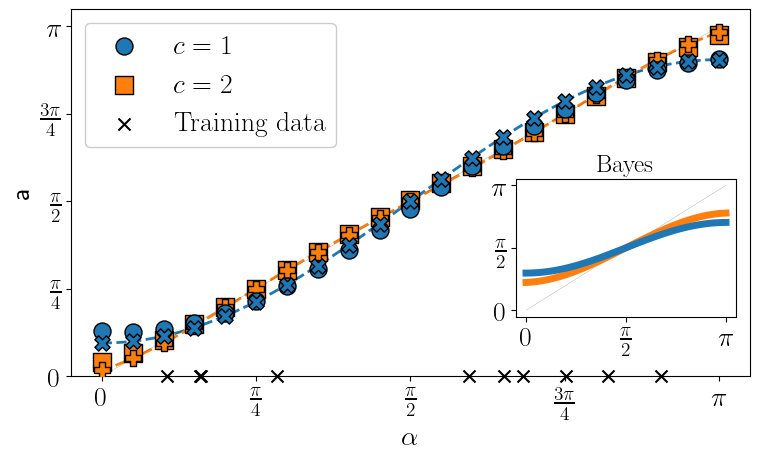

/tmp/ipykernel_864202/1220404514.py:61: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


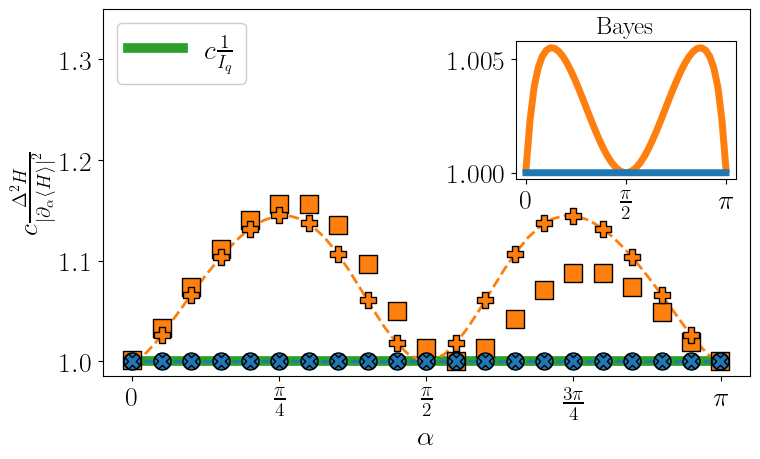

In [217]:
matplotlib.rcParams.update({'font.size': 20})

markers = ["o", "s", "^"]


fig, ax1 = plt.subplots(figsize=(8, 5))
# for i in range(len(n_copies_list)):
#     ax1.scatter(labels_test, aux_infos_list[i][0], s=150, ec="black", zorder=10-i, marker=markers[i], label=r"$c=%d$" %n_copies_list[i])
ax1.scatter(labels_test, aux_infos_list[0][0], s=150, ec="black", zorder=7, marker="o", label=r"$c=1$")
ax1.scatter(labels_test, aux_infos_list[1][0], s=150, ec="black", zorder=5, marker="s", label=r"$c=2$")
ax1.plot(linspace(0, pi, 50), expecs_1_theor, color="C0", linestyle="--", linewidth=2, zorder=0)
ax1.plot(linspace(0, pi, 50), expecs_2_theor, color="C1", linestyle="--", linewidth=2, zorder=0)
ax1.scatter(labels_test, expecs_1_inf, s=120, ec="black", color="C0", marker="X", zorder=8)
ax1.scatter(labels_test, expecs_2_inf, s=120, ec="black", color="C1", marker="P", zorder=6)
ax1.plot(linspace(0, pi, 50), linspace(0, pi, 50), color="black", linestyle="-", linewidth=0.1, zorder=0)
ax1.scatter(labels_train, [0]*T, color="black", s=75, marker="x", clip_on=False, zorder=10, label="Training data") # 
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel(r"$\mathsf{a}$")
ax1.set_xticks([0, pi/4, pi/2, 3*pi/4, pi], [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
ax1.set_yticks([0, pi/4, pi/2, 3*pi/4, pi], [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
# ax1.grid()
ax1.legend(framealpha=1)
ax1.set_ylim(ymin=0)
ax2 = fig.add_axes([0.67, 0.325, 0.275, 0.275])
ax2.plot(linspace(0, pi, 50), expecs_1_bayes, color="C0", linestyle="-", linewidth=5, zorder=2)
ax2.plot(linspace(0, pi, 50), expecs_2_bayes, color="C1", linestyle="-", linewidth=5, zorder=1)
ax2.plot(linspace(0, pi, 50), linspace(0, pi, 50), color="black", linestyle="-", linewidth=0.1, zorder=0)
ax2.set_xticks([0, pi/2, pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
ax2.set_yticks([0, pi/2, pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
ax2.set_title("Bayes", fontsize=18)
ax2.patch.set_facecolor('white')
# ax2.grid()
fig.tight_layout()
# plt.savefig(save_path + file_info + "-est.pdf", transparent=True, bbox_inches='tight')
plt.show()

fig, ax1 = plt.subplots(figsize=(8, 5))
# for i in range(len(n_copies_list)):
#     ax1.scatter(labels_test, n_copies_list[i]*aux_infos_list[i][2]/aux_infos_list[i][1]**2, ec="black", zorder=10-i, s=150, marker=markers[i])
    # ax1.plot(labels_test, n_copies_list[i]/aux_infos_list[i][3], linestyle="--", zorder=10-i)
# plt.plot(labels_test, n_copies/QFIs_test, color="tab:green", linewidth=5, label=r"$c\frac{1}{I_q}$", zorder=0)
ax1.scatter(labels_test, n_copies_list[0]*aux_infos_list[0][2]/aux_infos_list[0][1]**2, ec="black", zorder=7, s=150, marker="o", color="C0")
ax1.scatter(labels_test, n_copies_list[1]*aux_infos_list[1][2]/aux_infos_list[1][1]**2, ec="black", zorder=5, s=150, marker="s", color="C1")
ax1.plot(linspace(0, pi, 50)[1:-1], disps_1_theor[1:-1]/expecs_der_1_theor[1:-1]**2, color="C0", linestyle="--", linewidth=2, zorder=2)
ax1.plot(linspace(0, pi, 50), 2*disps_2_theor/expecs_der_2_theor**2, color="C1", linestyle="--", linewidth=2, zorder=1)
ax1.scatter(labels_test, disps_1_inf/expecs_der_1_inf**2, s=120, ec="black", color="C0", marker="X", zorder=8)
ax1.scatter(labels_test, 2*disps_2_inf/expecs_der_2_inf**2, s=120, ec="black", color="C1", marker="P", zorder=6)
ax1.plot(labels_test, [1]*len(labels_test), color="C2", linewidth=7, label=r"$c\frac{1}{I_q}$", zorder=0)
ax1.set_xlabel(r"$\alpha$")
ax1.set_ylabel(r"$c\frac{\Delta^2 H}{\left| \partial_\alpha \langle H \rangle \right|^2}$" )
ax1.set_xticks([0, pi/4, pi/2, 3*pi/4, pi], [r"$0$", r"$\frac{\pi}{4}$", r"$\frac{\pi}{2}$", r"$\frac{3\pi}{4}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
ax1.set_ylim(ymin=0.985, ymax=1.35)
# ax1.set_ylim(ymax=1.35)
# ax1.grid()
ax1.legend(framealpha=1, loc=2)
ax2 = fig.add_axes([0.67, 0.6, 0.275, 0.275])
ax2.plot(linspace(0, pi, 50), disps_1_bayes/expecs_der_1_bayes**2, color="C0", linestyle="-", linewidth=5, zorder=2)
ax2.plot(linspace(0, pi, 50), 2*disps_2_bayes/expecs_der_2_bayes**2, color="C1", linestyle="-", linewidth=5, zorder=1)
ax2.set_xticks([0, pi/2, pi], [r"$0$", r"$\frac{\pi}{2}$", r"$\pi$"]) # plt.xticks([i*pi/(4) for i in range(5)], [r"$" + str(i) + "\pi$" for i in range(5)])
ax2.set_title("Bayes", fontsize=18)
fig.tight_layout()
# plt.savefig(save_path + file_info + "-var.pdf", transparent=True, bbox_inches='tight')
plt.show()